##Importing all required libraries for the project at the start

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import yfinance as yf

plt.style.use('seaborn-darkgrid')

###Taking realtime data from Yfinace and indexing it accordingly

In [ ]:
# btc_input_df = pd.read_csv(root_path, nrows=500)
btc_input_df = yf.download('BTC-USD',period='4000d',interval='1d')
btc_input_df.reset_index(inplace=True)
btc_input_df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


###Checking shape of data

In [ ]:
btc_input_df.shape

(3171, 7)

Description of dataset

In [ ]:
btc_input_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3.171000e+03
mean,13397.773933,13728.540408,13033.982863,13404.790816,13404.790816,1.659819e+10
std,16033.836956,16438.571140,15569.722483,16030.766993,16030.766993,1.965201e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,740.042511,747.223480,731.784515,740.558990,740.558990,1.212755e+08
50%,7469.729980,7641.363770,7326.192383,7480.140137,7480.140137,9.660610e+09
75%,19418.695312,19797.619141,19075.211914,19423.113281,19423.113281,2.779643e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [ ]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3171 non-null   datetime64[ns]
 1   Open       3171 non-null   float64       
 2   High       3171 non-null   float64       
 3   Low        3171 non-null   float64       
 4   Close      3171 non-null   float64       
 5   Adj Close  3171 non-null   float64       
 6   Volume     3171 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 173.5 KB


In [ ]:
btc_input_df_datetype = btc_input_df.astype({'Date': 'datetime64'})

In [ ]:
btc_input_df_datetype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3171 non-null   datetime64[ns]
 1   Open       3171 non-null   float64       
 2   High       3171 non-null   float64       
 3   Low        3171 non-null   float64       
 4   Close      3171 non-null   float64       
 5   Adj Close  3171 non-null   float64       
 6   Volume     3171 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 173.5 KB


In [ ]:
print('Null Values:',btc_input_df_datetype.isnull().values.sum())
print('If any NA values:', btc_input_df_datetype.isnull().values.any())


Null Values: 0
If any NA values: False


In [ ]:
btc_input_df_datetype.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3166,2023-05-19,26826.753906,27128.619141,26700.210938,26890.128906,26890.128906,11258983301
3167,2023-05-20,26888.841797,27155.158203,26843.277344,27129.585938,27129.585938,7044911360
3168,2023-05-21,27118.423828,27265.917969,26706.921875,26753.826172,26753.826172,8647416921
3169,2023-05-22,26749.892578,27045.734375,26549.734375,26851.277344,26851.277344,11056770492
3170,2023-05-23,26854.099609,27428.402344,26821.138672,27164.318359,27164.318359,13554236416


In [ ]:
btc_input_df_datetype.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


<Axes: title={'center': 'Bitcoin  Weighted Price'}, xlabel='Date'>

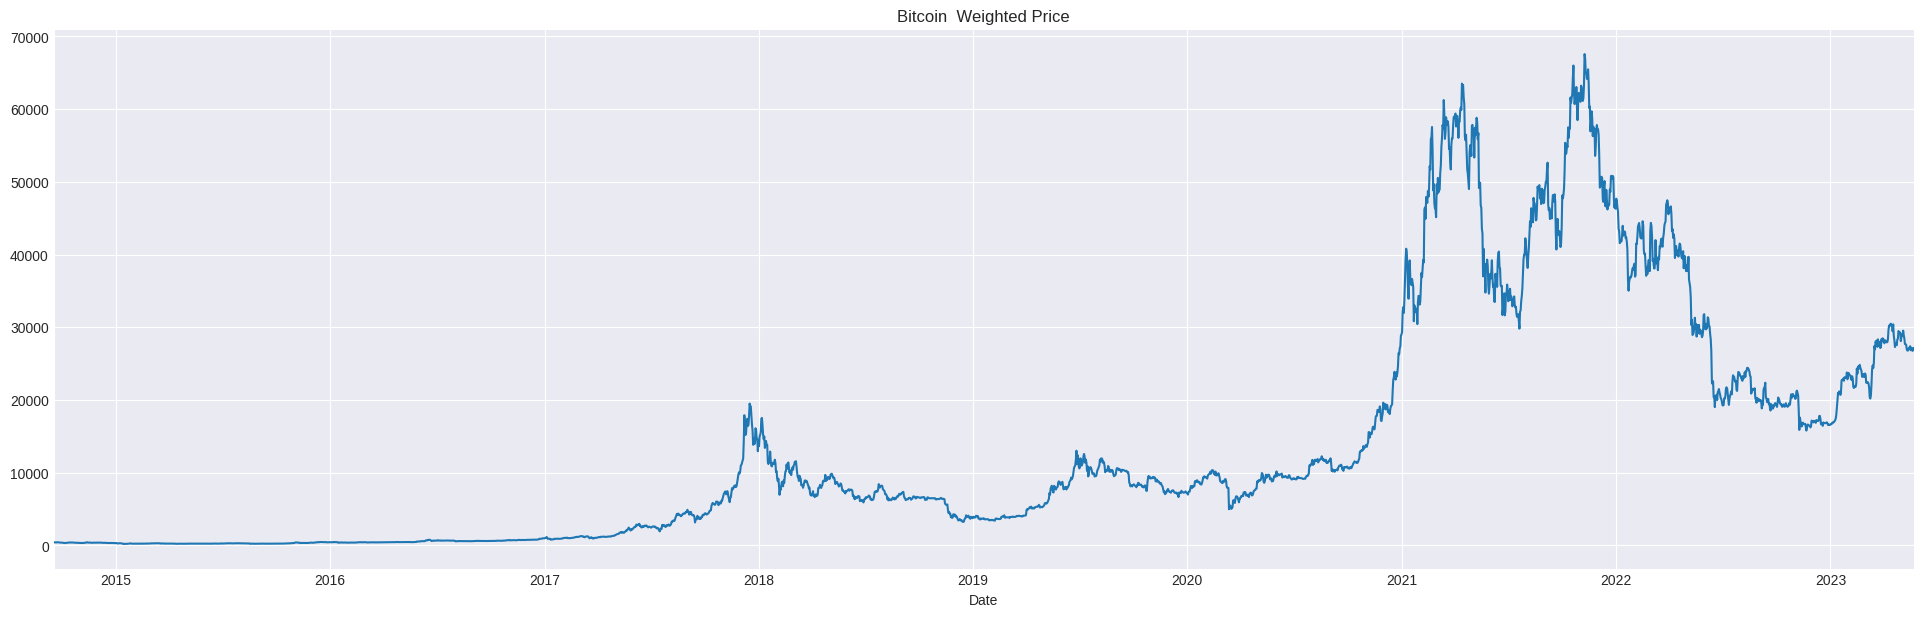

In [ ]:
btc_input_df_datetype.set_index("Date").Close.plot(figsize=(24,7), title="Bitcoin  Weighted Price")

# Lag Plot
Lag plot are used to observe the autocorrelation. These are crucial when we try to correct the trend and stationarity and we have to use smoothing functions. Lag plot helps us to understand the data better

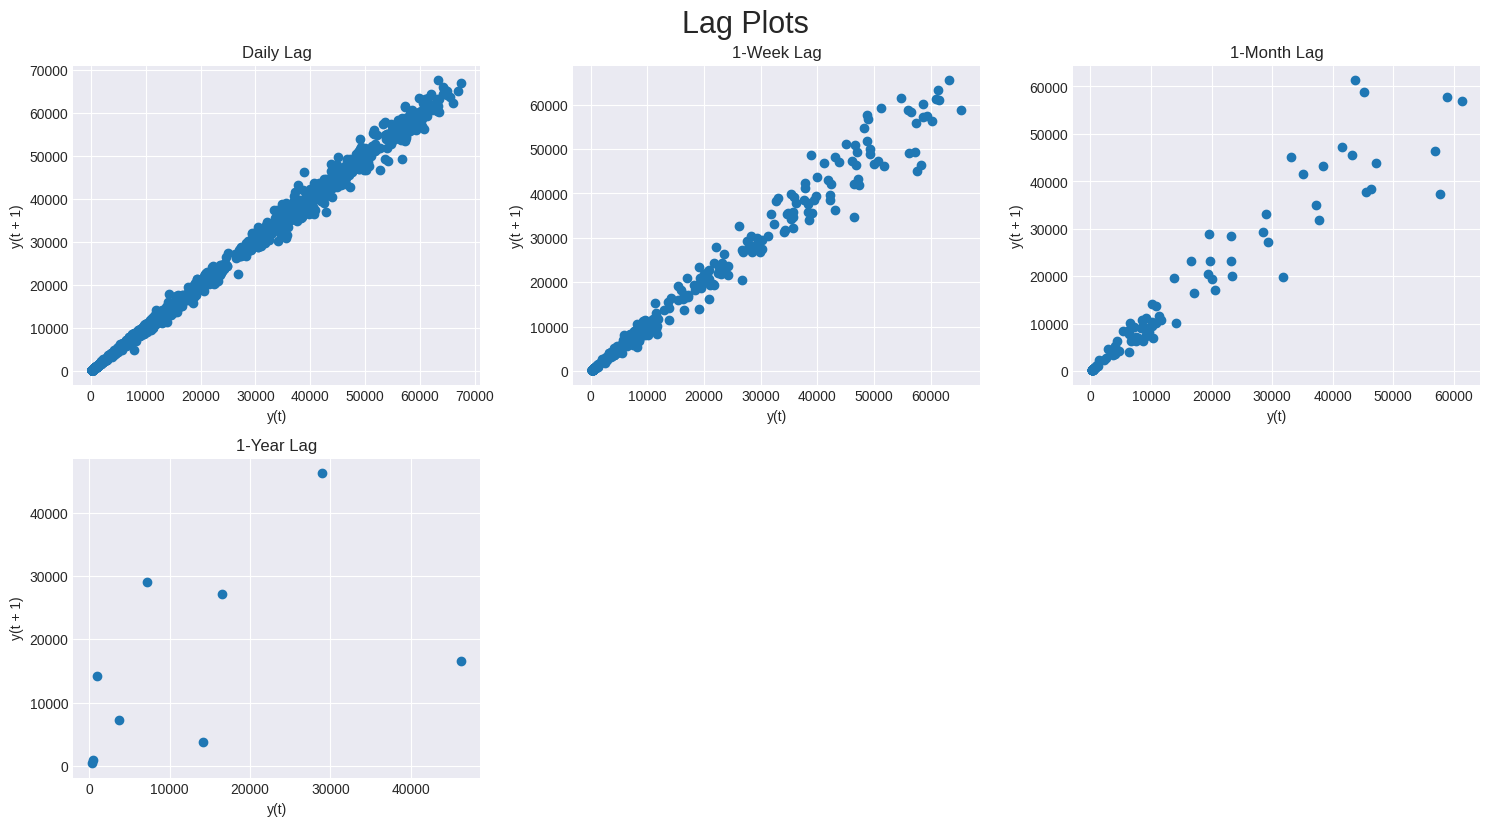

In [ ]:
btc_input_df.reset_index(inplace=True)
btc_input_df['Date'] = pd.to_datetime(btc_input_df['Date'])
btc_input_df.set_index('Date', inplace=True)
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
# Resample the data to daily frequency
btc_input_df_daily = btc_input_df.resample('D').last()
# Create the lag plot with a lag of 1 week
pd.plotting.lag_plot(btc_input_df['Close'], lag=1)
plt.title('Daily Lag')

plt.subplot(3, 3, 2)
# Resample the data to weekly frequency
btc_input_df_weekly = btc_input_df.resample('W').last()
# Create the lag plot with a lag of 1 week
pd.plotting.lag_plot(btc_input_df_weekly['Close'], lag=1)
plt.title('1-Week Lag')

plt.subplot(3, 3, 3)
# Resample the data to monthly frequency
btc_input_df_monthly = btc_input_df.resample('M').last()
# Create the lag plot with a lag of 1 month
pd.plotting.lag_plot(btc_input_df_monthly['Close'], lag=1)
plt.title('1-Month Lag')

plt.subplot(3, 3, 4)
# Resample the data to yearly frequency
btc_input_df_yearly = btc_input_df.resample('Y').last()
# Create the lag plot with a lag of 1 year
pd.plotting.lag_plot(btc_input_df_yearly['Close'], lag=1)
plt.title('1-Year Lag')

plt.tight_layout()
plt.show()

We can see that there is a positive correlation for minute, hour and daily lag plots.

Correlation decreases drastically with Weekly Lag and absolutely no correlation for month lag plots.

It makes sense to re-sample our data atmost at the Daily level, thereby preserving the autocorrelation as well.


# grouping data on daily basis
The unit of the arg (D,s,ms,us,ns) denote the unit, which is an integer or float number. This will be based off the origin. Example, with unit=’ms’ and origin=’unix’ (the default), this would calculate the number of milliseconds to the unix epoch start.



In [ ]:
display(btc_input_df_datetype.head())
group = btc_input_df_datetype.groupby('Date')
btc_closing_price_groupby_date = group['Close'].mean()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
display(btc_closing_price_groupby_date.head(10))

print("Length of btc_closing_price_groupby_date :", len(btc_closing_price_groupby_date))

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
2014-09-22    402.152008
2014-09-23    435.790985
2014-09-24    423.204987
2014-09-25    411.574005
2014-09-26    404.424988
Name: Close, dtype: float64

Length of btc_closing_price_groupby_date : 3171


#Train Test Split

In [ ]:
prediction_days = 100

# Set Train data to be uplo ( Total data length - prediction_days )
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)


# Set Test data to be the last prediction_days (or 60 days in this case)
df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [ ]:
df_test.shape

(100, 1)

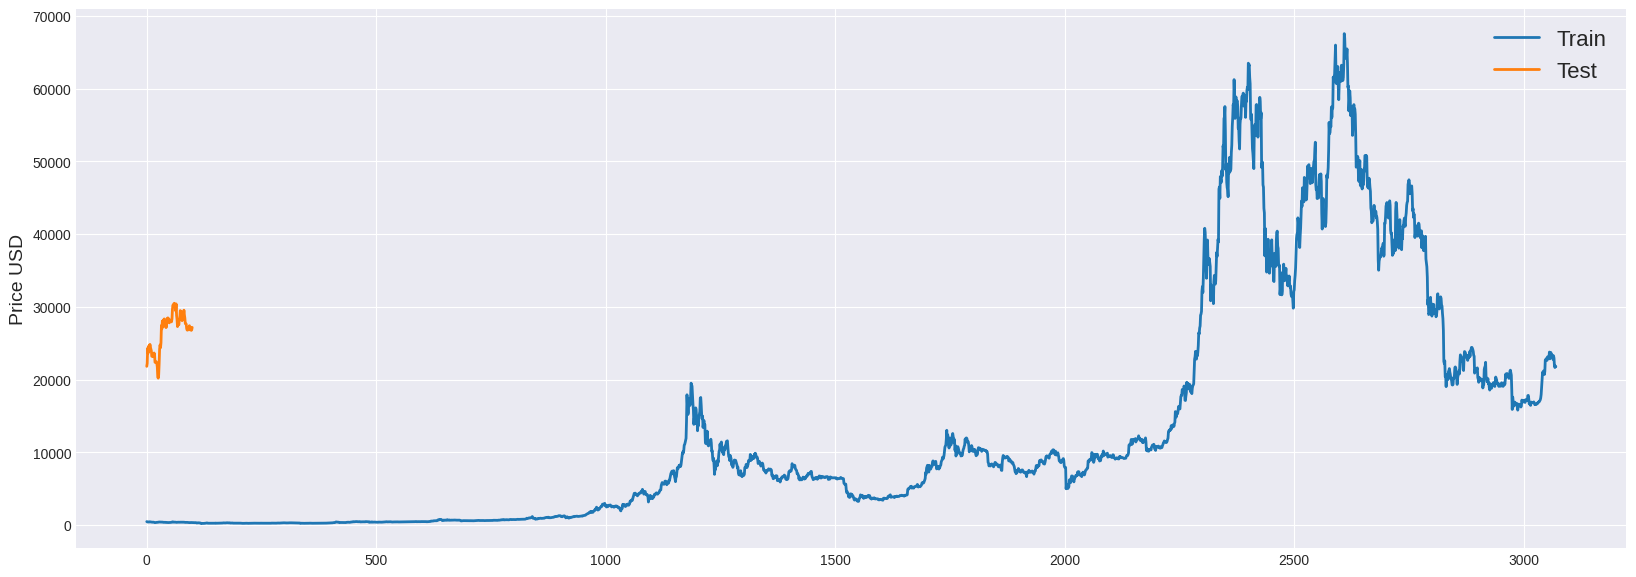

In [ ]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(20, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

# Min Max Scaling of Data post Train-Test Split
Scaling must be done after the data has been split into training and test sets — with each being scaled separately.

A common mistake when first using the LSTM is to first normalize the data before splitting the data.

The reason this is erroneous is that the normalization technique will use data from the test sets as a reference point when scaling the data as a whole. This will inadvertently influence the values of the training data, essentially resulting in data leakage from the test sets.

In [ ]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

#Dataset Generator for LSTM
We will frame the problem to take a window of the last so many number of days of data to predict the current days data.

To achieve this, we will define a new function named dataset_generator_lstm() that will split the input sequence into windows of data appropriate for fitting a supervised learning model, like an LSTM

For example, if the sequence was:

1, 2, 3, 4, 5, 6, 7, 8, 9, 10

Then the samples for training the model will look like:


Input 				| Output
1, 2, 3, 4, 5 		6
2, 3, 4, 5, 6 		7
3, 4, 5, 6, 7 		8

LSTMs expect each sample in the dataset to have two dimensions; the first is the number of time steps (in the above case it is 5), and the second is the number of observations per time step (in this case it is 1).

Because it is a regression type problem, we will use a linear activation function in the output layer and optimize the mean squared error loss function. We will also evaluate the model using the mean squared error (MAE) metric.

##Define look_back period
A “lookback period” defines how many previous timesteps are used in order to predict the subsequent timestep.
For example if we set the lookback period to 5, that means that  we are using the time steps at t-4, t-3, t-2, t-1, and t to predict the value at time t+1.

For our case below, we will be using a one-step prediction model.

##Lookback period
lookback = 5

X_train, Y_train = dataset_generator_lstm(train, lookback)

X_val, Y_val = dataset_generator_lstm(val, lookback)
##Quick note on Python slice notation for slicing an array
[1:5] is equivalent to "from 1 to 5" (5 not included)

[1:] is equivalent to "1 to end"

[len(a):] is equivalent to "from length of a to end"

In the below function we will generate the train_X array and train_y array for feeding into the LSTM


In [ ]:
def dataset_generator_lstm(dataset, look_back=5):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep.
    dataX, dataY = [], []

    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (3066, 5)
trainY:  (3066,)
testX:  (95, 5)
testY (95,)


In [ ]:
print("trainX: ", trainX)
# print("trainY: ", trainY)
# print("testY: ", testX)
# print("testY", testY)

trainX:  [[0.00414359 0.00365546 0.00321557 0.00342492 0.0032753 ]
 [0.00365546 0.00321557 0.00342492 0.0032753  0.00332473]
 [0.00321557 0.00342492 0.0032753  0.00332473 0.0038239 ]
 ...
 [0.33800258 0.33510066 0.34258235 0.33776118 0.32113586]
 [0.33510066 0.34258235 0.33776118 0.32113586 0.318645  ]
 [0.34258235 0.33776118 0.32113586 0.318645   0.32190507]]


#For LSTM I need to reshape input to be a 3D Tensor of [samples, time steps, features]
**X** = numpy.reshape(dataX, (len(dataX), seq_length, 1))

**Samples** - This is the len(dataX), or the amount of data points you have.

**Time steps**- A sample contains multiple time steps, that is, the width of the sliding window (according to the above example, the time step is 3). Note here that it is distinguished from the sliding step of the sliding window. This is equivalent to the amount of time steps you run your recurrent neural network. If you want your network to have memory of 60 characters, this number should be 60. For this notebook, we are using the window-size to be 5.

**Features**- this is the amount of features in every time step. If you are processing pictures, this is the amount of pixels. In this case we have 1 feature (the price of Bitcoin) per time step.

##According to the documentation and the source code, the Keras LSTM input data must be in the form: [batch_size, timesteps, input_dim].
In Keras, the number of time steps is equal to the number of LSTM cells. This is what the word “time steps” means in the 3D tensor of the shape [batch_size, timesteps, input_dim].

##So to emphasize again, the input to every LSTM layer must be three-dimensional.
The three dimensions of this input are:
Samples. One sequence is one sample. A batch is comprised of one or more samples.

Time Steps. One time step is one point of observation in the sample.

Features. One feature is one observation at a time step.

This means that the input layer expects a 3D array of data when fitting the model and when making predictions, even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

#####When defining the input layer of your LSTM network, the network assumes you have 1 or more samples and requires that you specify the number of time steps and the number of features. You can do this by specifying a tuple to the “input_shape” argument.
---------------------------------------------------------------------------
##Example of LSTM With Single Input Sample where you have one sequence of multiple time steps and one feature.
For example, this could be a sequence of 10 values:

0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0

We can define this sequence of numbers as a NumPy array.

We can then use the reshape() function on the NumPy array to reshape this one-dimensional array into a three-dimensional array with 1 sample, 10 time steps, and 1 feature at each time step.

The reshape() function when called on an array takes one argument which is a tuple defining the new shape of the array. We cannot pass in any tuple of numbers; the reshape must evenly reorganize the data in the array.

Once reshaped, we can print the new shape of the array.
Putting all of this together, the complete example is listed below.

from numpy import array
data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

data = data.reshape((1, 10, 1))

print(data.shape)

Running the example prints the new 3D shape of the single sample.

(1, 10, 1)

This data is now ready to be used as input (X) to the LSTM with an input_shape of (10, 1).

model = Sequential()

model.add(LSTM(32, input_shape=(10, 1)))

model.add(Dense(1))

-------------------------------------------------------------------------------
#For LSTM Reshape input ( trainX and testX ) to be 3-D of [samples, time steps, features]
##First check the current shape of trainX and testX





In [ ]:
print(trainX.shape)
print(testX.shape)

(3066, 5)
(95, 5)


##And now reshape trainX and testX

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (3066, 5, 1)
Shape of testX:  (95, 5, 1)


In [ ]:
print("trainX: ", trainX)
print(" ********** ")
print("testX: ", testX)

trainX:  [[[0.00414359]
  [0.00365546]
  [0.00321557]
  [0.00342492]
  [0.0032753 ]]

 [[0.00365546]
  [0.00321557]
  [0.00342492]
  [0.0032753 ]
  [0.00332473]]

 [[0.00321557]
  [0.00342492]
  [0.0032753 ]
  [0.00332473]
  [0.0038239 ]]

 ...

 [[0.33800258]
  [0.33510066]
  [0.34258235]
  [0.33776118]
  [0.32113586]]

 [[0.33510066]
  [0.34258235]
  [0.33776118]
  [0.32113586]
  [0.318645  ]]

 [[0.34258235]
  [0.33776118]
  [0.32113586]
  [0.318645  ]
  [0.32190507]]]
 ********** 
testX:  [[[0.15738841]
  [0.19746268]
  [0.40011804]
  [0.33366466]
  [0.42514701]]

 [[0.19746268]
  [0.40011804]
  [0.33366466]
  [0.42514701]
  [0.43249528]]

 [[0.40011804]
  [0.33366466]
  [0.42514701]
  [0.43249528]
  [0.40204073]]

 [[0.33366466]
  [0.42514701]
  [0.43249528]
  [0.40204073]
  [0.45073793]]

 [[0.42514701]
  [0.43249528]
  [0.40204073]
  [0.45073793]
  [0.41259678]]

 [[0.43249528]
  [0.40204073]
  [0.45073793]
  [0.41259678]
  [0.3885631 ]]

 [[0.40204073]
  [0.45073793]
  [0.41259

##Let’s take a look at the normalized window for trainX.
[[[0.00000000e+00]

  [1.44159882e-04]

  [2.79473948e-04]

  [5.34851927e-04]

  [4.90695552e-04]]

 [[1.44159882e-04]

  [2.79473948e-04]

  [5.34851927e-04]

  [4.90695552e-04]

  [4.21819458e-04]]

 [[2.79473948e-04]

  [5.34851927e-04]

  [4.90695552e-04]

  [4.21819458e-04]

  [7.33745838e-04]]... ]

Above are the first three entries. We can see that the five time steps immediately prior to the one we are trying to predict move in a stepwise motion.

Consider the last value of the first window which is => 4.90695552e-04
#LSTM (Long Short-Term Memory) Mechanism
The Long Short-Term Memory, or LSTM, is a recurrent neural network that is comprised of internal gates.

Unlike other recurrent neural networks, the network’s internal gates allow the model to be trained successfully using backpropagation through time, or BPTT, and avoid the vanishing gradients problem.

In the Keras deep learning library, LSTM layers can be created using the LSTM() class.

Creating a layer of LSTM memory units allows you to specify the number of memory units within the layer.

Each unit or cell within the layer has an internal cell state, often abbreviated as “c“, and outputs a hidden state, often abbreviated as “h“.

The Keras API allows you to access these data, which can be useful or even required when developing sophisticated recurrent neural network architectures, such as the encoder-decoder model.
##input_shape of LSTM Model - input_shape is supposed to be (timesteps,n_features).
input_shape = (95000,360)

Keras LSTM takes and input with shape of (n_examples, n_times, n_features) and your layers input has to have this shape

To give you an example: if I'm observing the amount of rain and the temperature each hour for 24h in order to predict the weather (1 = good, 0 = bad), and I do that for 365 days, I will have 365 samples, each of which will have 24 timesteps, and 2 variables (one for rain, one for temperature), so my input is going to have the shape (365, 24, 2), and input_shape = (24, 2)
##return_sequences=True
The original LSTM model is comprised of a single hidden LSTM layer followed by a standard feedforward output layer.

The Stacked LSTM is an extension to this model that has multiple hidden LSTM layers where each layer contains multiple memory cells.

You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer has a compatible n-dimensional sequence input.

###To stack LSTM layers, we need to change the configuration of the prior LSTM layer to output a compatible n-dim array as input for the subsequent layer.
We can do this by setting the return_sequences argument on the layer to True (defaults to False). This will return one output for each input time step and provide the compatible n-dim array.
#Why Increase Depth of an LSTM ?
Stacking LSTM hidden layers makes the model deeper, more accurately earning the description as a deep learning technique.

It is the depth of neural networks that is generally attributed to the success of the approach on a wide range of challenging prediction problems.

Additional hidden layers can be added to a Multilayer Perceptron neural network to make it deeper. The additional hidden layers are understood to recombine the learned representation from prior layers and create new representations at high levels of abstraction. For example, from lines to shapes to objects.

A sufficiently large single hidden layer Multilayer Perceptron can be used to approximate most functions. Increasing the depth of the network provides an alternate solution that requires fewer neurons and trains faster. Ultimately, adding depth it is a type of representational optimization.

Given that LSTMs operate on sequence data, it means that the addition of layers adds levels of abstraction of input observations over time. In effect, chunking observations over time or representing the problem at different time scales.

Stacked LSTMs are now a stable technique for challenging sequence prediction problems.
#Final LSTM

In [ ]:
# First checking the values for input_shape = (trainX.shape[1], trainX.shape[2])
# Note - `input_shape` of LSTM Model - `input_shape` is supposed to be (timesteps, n_features).

print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  5
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


In [ ]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# Note - If I plan to add 3-rd or 4-th layers of LSTM then
# I must set return_sequences=True in the 2-nd layer above
# so that the 3-rd LSTM layer has a compatible n-dimensional sequence input.


# Adding a third LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]
# callbacks = [checkpoint]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/600
96/96 [==============================] - ETA: 0s - loss: 0.0123
Epoch 1: val_loss improved from inf to 0.13196, saving model to my_best_model.hdf5
96/96 [==============================] - 8s 21ms/step - loss: 0.0123 - val_loss: 0.1320
Epoch 2/600
93/96 [============================>.] - ETA: 0s - loss: 0.0272
Epoch 2: val_loss improved from 0.13196 to 0.05287, saving model to my_best_model.hdf5
96/96 [==============================] - 1s 15ms/step - loss: 0.0271 - val_loss: 0.0529
Epoch 3/600
93/96 [============================>.] - ETA: 0s - loss: 0.0350
Epoch 3: val_loss improved from 0.05287 to 0.01799, saving model to my_best_model.hdf5
96/96 [==============================] - 1s 14ms/step - loss: 0.0354 - val_loss: 0.0180
Epoch 4/600
93/96 [============================>.] - ETA: 0s - loss: 0.0218
Epoch 4: val_loss improved from 0.01799 to 0.01502, saving model to my_best_model.hdf5
96/96 [==============================] - 1s 14ms/step - loss: 0.0213 - val_loss: 0.0150


#Plot line graph to show Loss Numbers relative to the epoch

In [ ]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

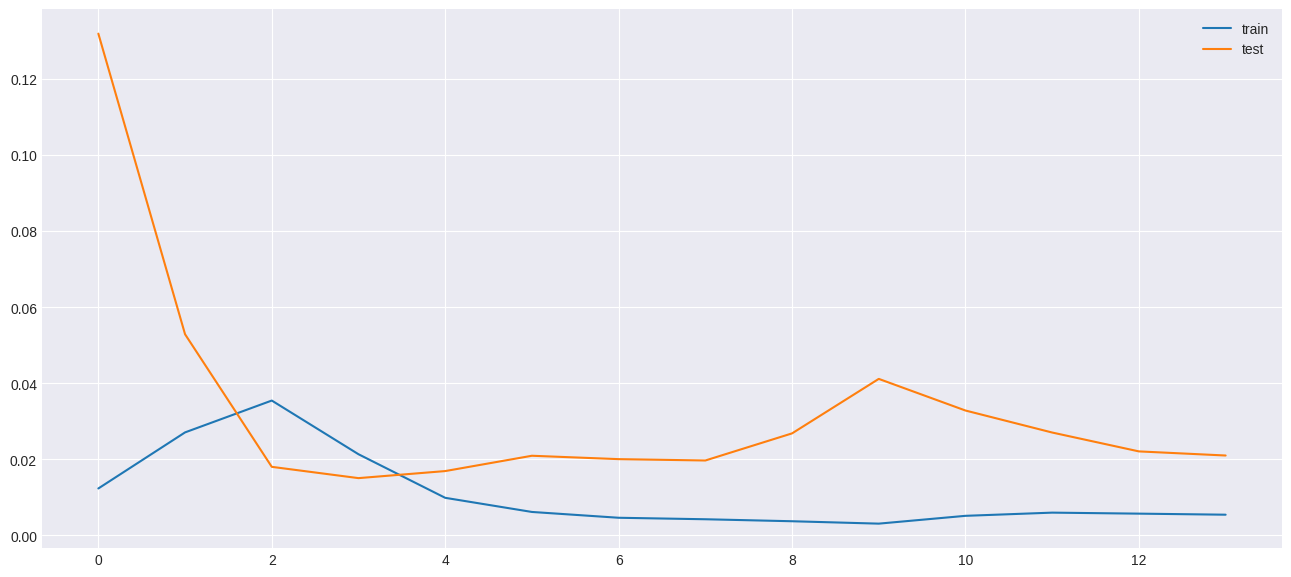

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#LSTM Predictions using testX and plotting line graph against Actual testY
Due to scaling step done earlier with MinMaxScaler the predicted scale is between 0 and 1. Now, we need to transfer this scale to the original data scale (real value). for example:[0.58439621 0.58439621 0.58439621 ... 0.81262134 0.81262134 0.81262134], the pred answer transfer to :[250 100 50 60 .....] So here we are going to use inverse_transform to Scale back the data to the original representation.

In [ ]:
# Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

3/3 [==============================] - 1s 7ms/step


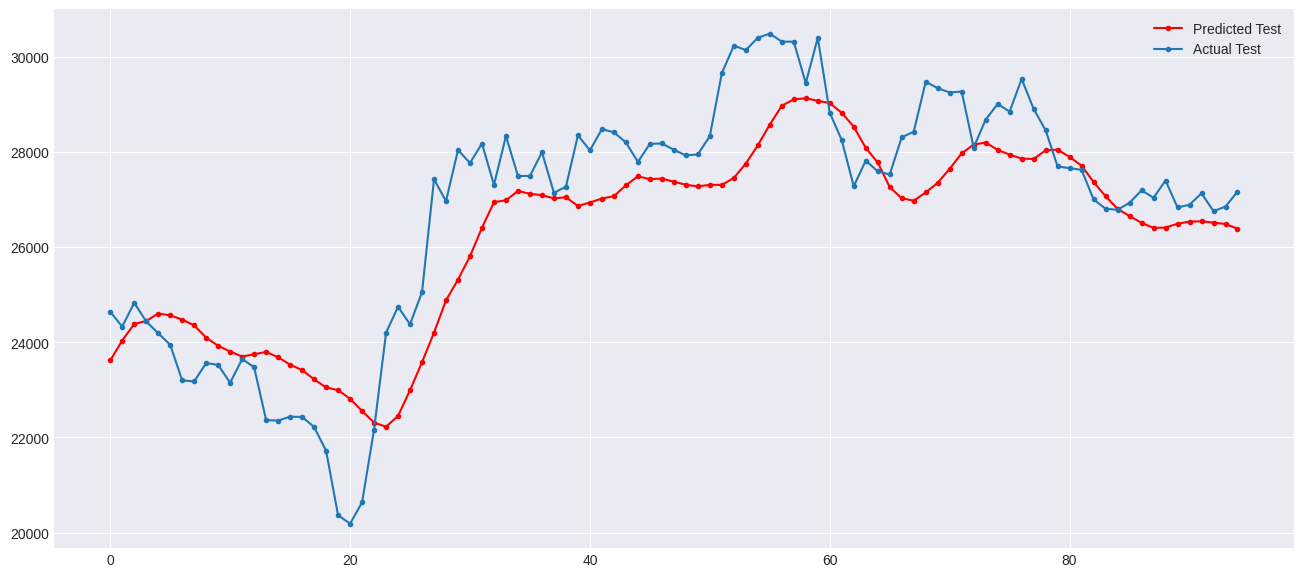

In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

#LSTM Prediction using trainX and plotting line graph against Actual trainY

In [ ]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

96/96 [==============================] - 0s 4ms/step


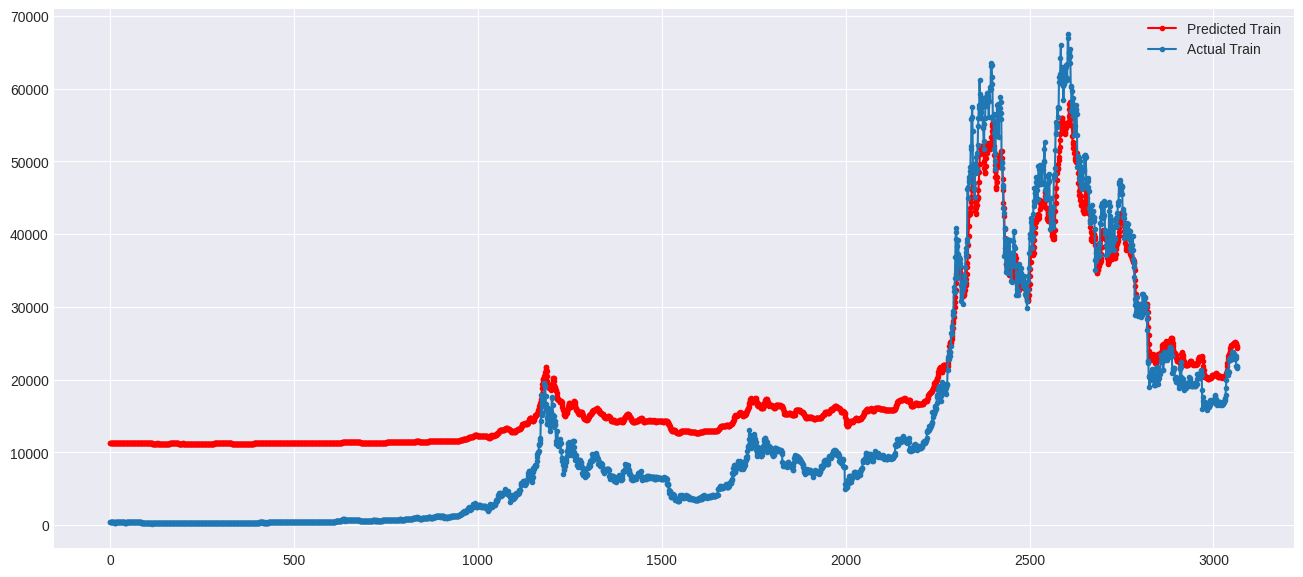

In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

#RMSE - Test Data

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)
ape = np.abs((test_actual - predicted_btc_price_test_data) / test_actual)

# Calculate the mean absolute percentage error
mape = np.mean(ape)

# Calculate the accuracy using MAPE
accuracy = 100 - mape

print("Accuracy:", accuracy)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1666.162  => This seems best

Test RMSE: 1262.268
Accuracy: 99.96185735414976


#RMSE - Train Data

In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)
ape = np.abs((train_actual - predicted_btc_price_train_data) / train_actual)

# Calculate the mean absolute percentage error
mape = np.mean(ape)

# Calculate the accuracy using MAPE
accuracy = 100 - mape

print("Accuracy:", accuracy)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1047.916  => This seems best

Test RMSE: 8012.384
Accuracy: 90.67185872438662


#Now Future Price Predictions - For 5 Days beyond the actual trading days for which I dont have the ground truth data (i.e. for 5-days into future for which I dont have actual Trading Price yet)
Note that the original Trading data (the .csv file used at the very top of this notebook) ended on 24-May-2023, but now we are going to forecast the Bitcoin Prices for 5 days beyond 24-May-2023, using the trained LSTM model above.

First check the shape of testX

Basically to predict tomorrow's value,

feed into the model the past n(look_back) days’ values and we get tomorrow’s value as output.

Similarly, to get the day after tomorrow’s value, feed-in past n-1 days’ values along with tomorrow’s value and the model output day after tomorrow’s value.

In [ ]:
testX
testX.shape

(95, 5, 1)

In [ ]:
lookback_period = 5

# That is the original Trading data ended on 24-May-2023, but now we are going to forecast for Future 5 days beyond 24-May-2023

testX_last_5_days = testX[testX.shape[0] - lookback_period :  ]

testX_last_5_days.shape

(5, 5, 1)

In [ ]:
testX_last_5_days

array([[[0.65479671],
        [0.68024273],
        [0.66509066],
        [0.70025635],
        [0.645239  ]],

       [[0.68024273],
        [0.66509066],
        [0.70025635],
        [0.645239  ],
        [0.65086314]],

       [[0.66509066],
        [0.70025635],
        [0.645239  ],
        [0.65086314],
        [0.67411488]],

       [[0.70025635],
        [0.645239  ],
        [0.65086314],
        [0.67411488],
        [0.63762788]],

       [[0.645239  ],
        [0.65086314],
        [0.67411488],
        [0.63762788],
        [0.64709057]]])

In [ ]:
predicted_5_days_forecast_price_test_x = []

for i in range(5):
  predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_days[i:i+1])

  predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x))
# That is the original Trading data ended on 24-May-2023, but now I am going to forecast beyond 24-May-2023

1/1 [==============================] - 0s 22ms/step
Forecast for the next 5 Days Beyond the actual trading days  [[[26535.746]]

 [[26541.006]]

 [[26513.506]]

 [[26484.36 ]]

 [[26386.629]]]


In [ ]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

predicted_5_days_forecast_price_test_x.shape

(5, 1, 1)

In [ ]:
predicted_btc_price_test_data.shape

(95, 1)

In [ ]:
predicted_btc_price_test_data

array([[23616.068],
       [24034.695],
       [24384.602],
       [24445.346],
       [24602.984],
       [24565.682],
       [24476.74 ],
       [24352.434],
       [24096.777],
       [23925.13 ],
       [23804.418],
       [23699.027],
       [23747.371],
       [23796.588],
       [23683.72 ],
       [23528.545],
       [23414.062],
       [23221.195],
       [23048.887],
       [22992.691],
       [22811.816],
       [22554.664],
       [22311.031],
       [22223.543],
       [22450.754],
       [22991.422],
       [23578.572],
       [24201.97 ],
       [24878.814],
       [25316.047],
       [25806.848],
       [26406.832],
       [26943.955],
       [26983.393],
       [27178.648],
       [27120.21 ],
       [27090.416],
       [27022.918],
       [27047.42 ],
       [26865.06 ],
       [26936.125],
       [27020.072],
       [27069.553],
       [27297.295],
       [27487.447],
       [27427.46 ],
       [27439.408],
       [27372.719],
       [27310.51 ],
       [27274.346],


In [ ]:
predicted_5_days_forecast_price_test_x

array([[[26535.746]],

       [[26541.006]],

       [[26513.506]],

       [[26484.36 ]],

       [[26386.629]]], dtype=float32)

In [ ]:
predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()

predicted_5_days_forecast_price_test_x

array([26774.129, 26645.434, 26650.895, 26740.092, 26793.818],
      dtype=float32)

In [ ]:
predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()

predicted_btc_price_test_data

array([22664.4  , 22696.162, 22953.146, 23220.191, 23605.352, 24040.562,
       24407.219, 24468.828, 24647.777, 24609.393, 24512.121, 24386.945,
       24109.773, 23922.115, 23786.04 , 23673.543, 23725.906, 23775.406,
       23659.295, 23505.135, 23389.238, 23193.041, 23021.709, 22965.7  ,
       22769.959, 22480.234, 22204.611, 22111.828, 22353.969, 22942.877,
       23563.16 , 24219.594, 24937.494, 25415.316, 25952.729, 26630.572,
       27245.297, 27292.252, 27518.99 , 27452.861, 27421.998, 27342.916,
       27376.049, 27166.963, 27246.059, 27335.293, 27381.48 , 27641.316,
       27862.584, 27798.13 , 27816.365, 27738.463, 27664.035, 27623.19 ,
       27665.842, 27661.523, 27814.934, 28142.85 , 28570.893, 29067.723,
       29519.816, 29675.695, 29701.025, 29649.918, 29597.316, 29368.805,
       29051.08 , 28560.355, 28223.902, 27623.564, 27350.03 , 27282.861,
       27475.96 , 27695.172, 28023.305, 28392.828, 28606.826, 28668.654,
       28499.457, 28384.338, 28282.715, 28262.025, 

In [ ]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_5_days_forecast_price_test_x))

predicted_btc_test_concatenated

predicted_btc_test_concatenated.shape

(100,)


#Finally Plot entire Predictions of Test Data (including the Future 5-days ) against Actual testY

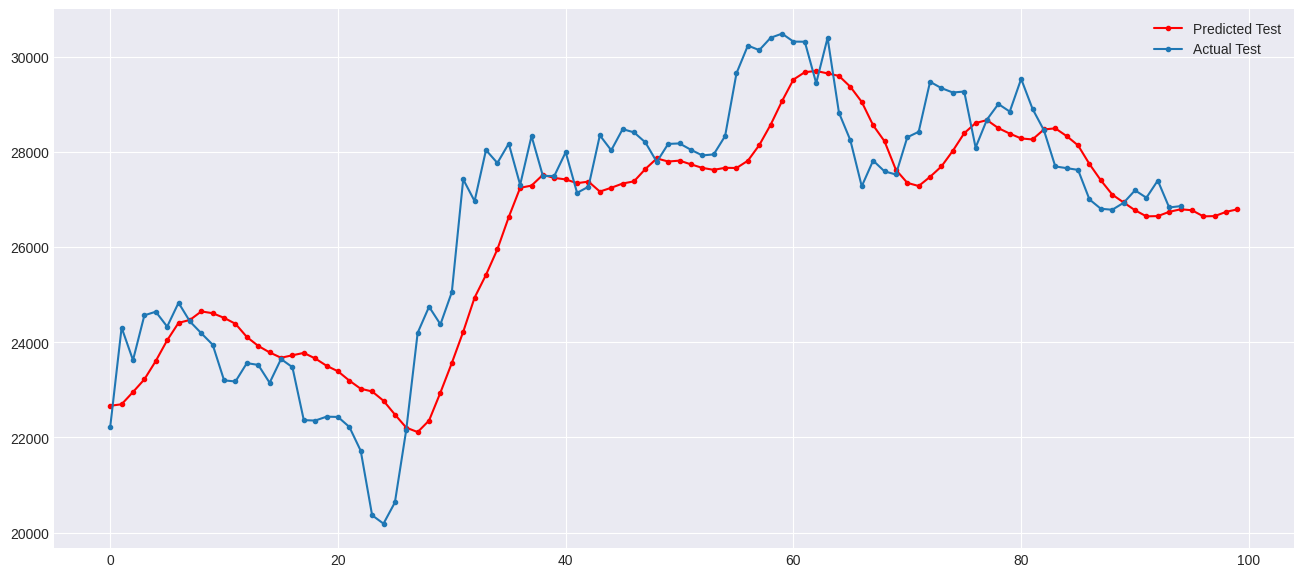

In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()

plt.show()